In [423]:
BASE_PATH = '../../../dynaphos-core/'

import os
import sys
sys.path.append(BASE_PATH)


import logging
import dynaphos
import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2

import ipywidgets as widgets

from dynaphos import utils
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.image_processing import canny_processor, sobel_processor
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from dynaphos.utils import get_data_kwargs, to_numpy

from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex, Map

COLORSTYLE = utils.load_params('../../_figurestyle/colors.yaml')

### Load default phosphene configuration

In [32]:
# read parameters from yaml file
params = utils.load_params(os.path.join(BASE_PATH, 'config','params.yaml'))
params['run']['gpu'] = 0
params['thresholding']['use_threshold'] = False
params['run']['batch_size'] = 5
params['sampling']['sampling_method'] = "center"
params['gabor']['gabor_filtering'] = True
params['gabor']['gamma'] = 3.5
params['run']['view_angle'] = 9 #in degrees, horizontal view angle
params['run']['origin'] = [15,0]

# initialise phopshene locations, either using a cortex model or semi-probabilistically
coordinates_cortex = utils.load_coordinates_from_yaml(os.path.join(BASE_PATH, 'config', 'grid_coords_dipole_valid.yaml'))
coordinates_cortex = Map(*coordinates_cortex)
coordinates_visual_field = get_visual_field_coordinates_from_cortex_full(params['cortex_model'], coordinates_cortex)

# Phosphene maps 
phosphene_maps = simulator.phosphene_maps

### Gabor phosphenes

In [419]:
# read parameters from yaml file
params = utils.load_params(os.path.join(BASE_PATH, 'config','params.yaml'))
params['run']['gpu'] = 0
params['thresholding']['use_threshold'] = False
params['run']['batch_size'] = 1
params['sampling']['sampling_method'] = "center"
params['gabor']['gabor_filtering'] = True
params['gabor']['gamma'] = 3.5
params['run']['view_angle'] = 9 #in degrees, horizontal view angle
params['run']['origin'] = [15,0]


# Phosphene coordinates
x, y, theta  = dynaphos.utils.load_params(os.path.join(BASE_PATH, 'config', 'grid_coords_gabor_small.yaml')).values()
phosphene_coordinates = Map(np.array(x), np.array(y))
simulator = PhospheneSimulator(params, phosphene_coordinates, theta=np.array(theta))

# Useful variables 
device = simulator.data_kwargs['device']
batch_size, n_phosphenes =  simulator.shape[:2]

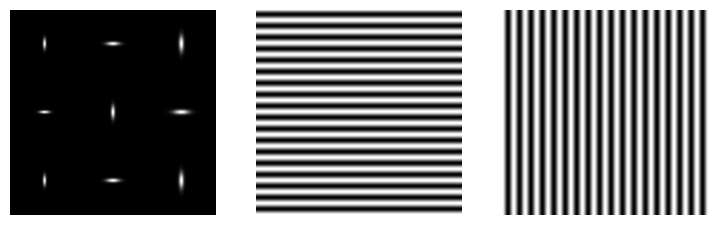

In [420]:
def plot(tensor, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    ax.imshow(tensor.detach().cpu(), origin='lower', cmap='gray')
    ax.axis('off')
    
def create_grating(frequency, angle, phase, imsize):
    # adapted from: https://www.baskrahmer.nl/blog/neuro/generating-gratings-in-python-using-numpy/

    # Get x and y coordinates
    r = torch.arange(0,imsize) #, imsize)
    x, y = torch.meshgrid(r, r)

    # Get the appropriate gradient
    angle = torch.tensor(angle)
    gradient = torch.sin(angle) * x - torch.cos(angle) * y
    return torch.sin((2 * torch.pi * gradient) / frequency + phase)
    

fig, axs = plt.subplots(1,3, figsize=(9,3))
    
# Example phosphene output
phs = simulator(torch.ones(batch_size, n_phosphenes, device=device)*100e-6)
plot(phs[0], axs[0])

# Create target images (gratings)
vertical = create_grating((256/18), 0, np.pi/2, 256).to(device).repeat(batch_size,1,1)
horizontal = create_grating((256/18), np.pi/2, np.pi/2, 256).to(device).repeat(batch_size,1,1)
plot(horizontal[0], axs[1])
plot(vertical[0], axs[2])

In [204]:
torch.use_deterministic_algorithms(False)

all_history = [] 

for img in [horizontal, vertical]:
    
    # initialize encoder & optimizer
    encoder = torch.nn.Linear(1,n_phosphenes).to(device)
    optimizer = torch.optim.Adam(encoder.parameters(), lr=0.8)

    # Loop over epochs
    history = {'image': [], 'stim': [], 'phosphenes': [], 'loss': []}
    for epoch in range(10000):
        simulator.reset()
        image = img
        stim = 100e-6 *torch.sigmoid(encoder(torch.ones(batch_size,1, device=device)))
        phosphenes = simulator(stim)
        loss = ((phosphenes - image )**2).mean()
        stats = {'image': image.detach().cpu().clone(), 
                 'stim': stim.detach().cpu().clone(), 
                 'phosphenes': phosphenes.detach().cpu().clone(), 
                 'loss': loss.item()}

        for k, v in stats.items():
            history[k].append(v)

        # Backward 
        optimizer.zero_grad()
        loss.backward(retain_graph=False)
        optimizer.step()
    
    all_history.append(history)
    
vert_history, horiz_history = all_history

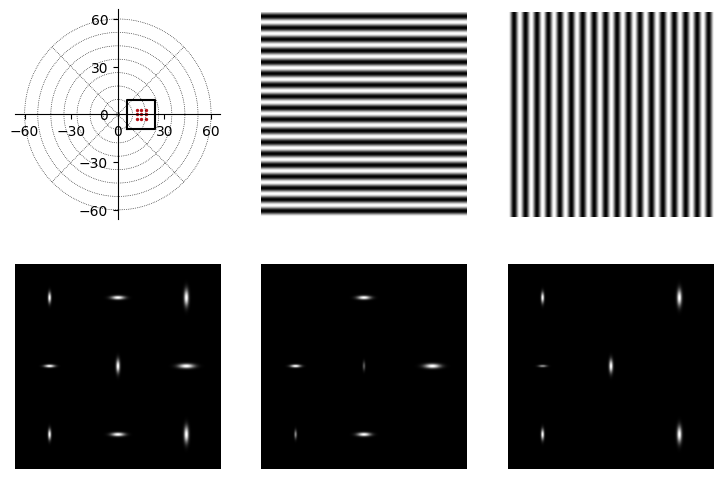

In [426]:
def plot_fov(ax):
    fov = params['run']['view_angle']
    org = params['run']['origin']

    # Plot the simulation FOV (square)
    x1, x2 = org[0]-fov, org[0] + fov
    y1, y2 = org[1]-fov, org[1] + fov
    ax.plot([x1,x1,x2,x2,x1], [y1,y2,y2,y1,y1], color='k')

    # Plot the radial lines
    for angle in np.linspace(-np.pi,np.pi,9) :
        r = []
        phi = []
        for radius in np.linspace(0,60,1000):
            r.append(radius)
            phi.append(angle)

        visual_field = Map(r = np.array(r), phi = np.array(phi))
        ax.plot(*visual_field.cartesian, 'k:',linewidth=.5)


    # Plot the concentric grid lines
    for radius in np.linspace(1,60,8):
        r = []
        phi = []
        for angle in np.linspace(-np.pi,np.pi,100):
            r.append(radius)
            phi.append(angle)

        visual_field = Map(r = np.array(r), phi = np.array(phi))
        ax.plot(*visual_field.cartesian, 'k:',linewidth=.5)

    ax.scatter(*phosphene_coordinates.cartesian, s=2, c=COLORSTYLE['red'][1])
    ax.spines[['left', 'bottom']].set_position('center')
    ax.spines[['right', 'top']].set_visible(False)
    ax.set(xticks=[-60,-30, 0,30,60], yticks=[-60,-30, 0,30,60])

    
fig, axs = plt.subplots(2,3, figsize=(9,6))
    
# Example phosphene output
plot_fov(axs[0][0])
phs = simulator(torch.ones(batch_size, n_phosphenes, device=device)*100e-6)
plot(phs[0], axs[1][0])
plot(horizontal[0], axs[0][1])
plot(vertical[0], axs[0][2])
plot(vert_history['phosphenes'][-1][0], axs[1][1])
plot(horiz_history['phosphenes'][-1][0], axs[1][2])



### Irregular shapes 

In [427]:
# read parameters from yaml file
params = utils.load_params(os.path.join(BASE_PATH, 'config','params.yaml'))
params['run']['gpu'] = 0
params['thresholding']['use_threshold'] = False
params['run']['batch_size'] = 1
params['sampling']['sampling_method'] = "center"
# params['gabor']['gabor_filtering'] = True
params['gabor']['gamma'] = 3.5
params['run']['view_angle'] = 9 #in degrees, horizontal view angle
params['run']['origin'] = [15,0]



### Interacting electrodes

In [471]:
def binary(x, bits):
    mask = 2**torch.arange(bits).to(x.device, x.dtype)
    return x.unsqueeze(-1).bitwise_and(mask).ne(0).byte()



In [473]:
# read parameters from yaml file
params = utils.load_params(os.path.join(BASE_PATH, 'config','params.yaml'))
params['run']['gpu'] = 0
params['thresholding']['use_threshold'] = False
params['run']['batch_size'] = 8
params['sampling']['sampling_method'] = "center"
params['gabor']['gamma'] = 3.5
params['run']['view_angle'] = 9 #in degrees, horizontal view angle
params['run']['origin'] = [15,15]


#### No interaction

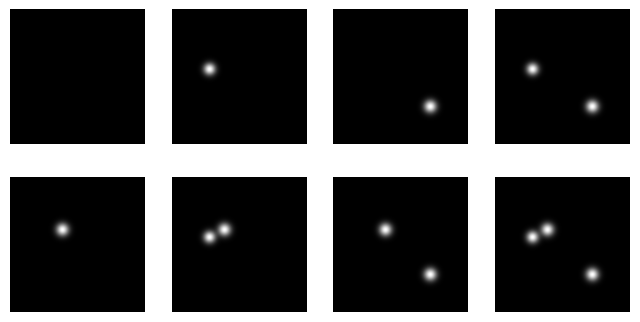

In [662]:
# Phosphene coordinates
x, y= ([13,17, 14], [15.5, 13, 16])
phosphene_coordinates = Map(np.array(x), np.array(y))
simulator = PhospheneSimulator(params, phosphene_coordinates)

# Useful variables 
device = simulator.data_kwargs['device']
batch_size, n_phosphenes =  simulator.shape[:2]
n_electrodes = len(x)


# Neutrally weighted interaction model
interaction_model = torch.nn.Linear(n_electrodes, n_phosphenes, bias=True)
interaction_model.weight.requires_grad = False
interaction_model.bias.requires_grad = False
interaction_model.weight.data = torch.eye(n_phosphenes,n_electrodes, device=device)
interaction_model.bias.data = torch.zeros(n_phosphenes, device=device)

stim = binary(torch.arange(8, device=device),3) * 100e-6
phs = simulator(interaction_model(stim))

fig, axs = plt.subplots(2,4, figsize=(8,4))
for i in range(2):
    for j in range(4):
        plot(phs[4*i+j], ax=axs[i][j])

#### Coactivation

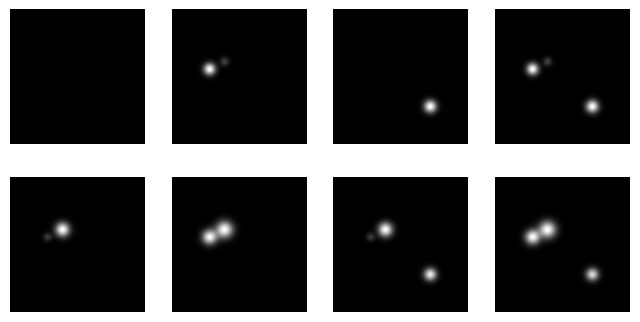

In [663]:
# Neutrally weighted interaction model
interaction_model = torch.nn.Linear(n_electrodes, n_phosphenes, bias=True)
interaction_model.weight.requires_grad = False
interaction_model.bias.requires_grad = False
interaction_model.weight.data = torch.eye(n_phosphenes,n_electrodes, device=device)
interaction_model.bias.data = torch.zeros(n_phosphenes, device=device)

# Coactivation
w = interaction_model.weight.data
interaction_model.weight.data[0] += .5 * w[2]
interaction_model.weight.data[2] += .5 * w[0]

stim = binary(torch.arange(8, device=device),3) * 100e-6
phs = simulator(interaction_model(stim))

fig, axs = plt.subplots(2,4, figsize=(8,4))
for i in range(2):
    for j in range(4):
        plot(phs[4*i+j], ax=axs[i][j])

#### Arbitrary extra phosphene 
When two electrodes are activated simultaneously, a different percept is created (e.g. a merged phosphene at a location in between the original phosphenes)


###### Note: the code below now only works for binary activation

In [664]:
def merge(coordinates, pairs):
    x,y = coordinates.cartesian
    for idx0, idx1 in pairs:
        x_new = np.mean([x[idx0], x[idx1]], keepdims=True)
        y_new = np.mean([y[idx0], y[idx1]], keepdims=True)
        x = np.concatenate([x, x_new])
        y = np.concatenate([y, y_new])
    return Map(x=x, y=y)

# Phosphene coordinates
x, y= ([13,17, 14], [15.5, 13, 16])
phosphene_coordinates = Map(np.array(x), np.array(y))
phosphene_coordinates = merge(phosphene_coordinates, [(0,2)])
simulator = PhospheneSimulator(params, phosphene_coordinates)

# Useful variables 
device = simulator.data_kwargs['device']
batch_size, n_phosphenes =  simulator.shape[:2]
n_electrodes = len(x)

tensor([[0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 1.0000]], device='cuda:0')

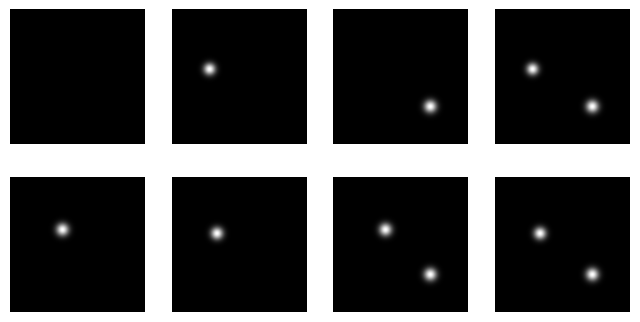

In [665]:
# Scale of binary stimulation
SCALE = 100e-6

# indices of interaciton electrodes and the extra phosphene percept
el_a, el_b = 0, 2
perc_a, perc_b, perc_x = 0, 2, 3

# Neutrally weighted interaction model
interaction_model = torch.nn.Sequential(torch.nn.Linear(n_electrodes, n_phosphenes, bias=True),
                                        torch.nn.Linear(n_phosphenes,n_phosphenes, bias=True),
                                        torch.nn.ReLU(), )

# neutral model
for p in interaction_model.parameters():
    p.requires_grad = False
interaction_model[0].weight.data = torch.eye(n_phosphenes, n_electrodes, device=device)
interaction_model[0].bias.data = torch.zeros(n_phosphenes, device=device)
interaction_model[1].weight.data = torch.eye(n_phosphenes, n_phosphenes, device=device)
interaction_model[1].bias.data = torch.zeros(n_phosphenes, device=device)


# Weights are initialized to mimic logical XOR operator for the original percepts
# and the AND operator for the additional (merged) percept
w0 = interaction_model[0].weight.data
b0 = interaction_model[0].bias.data
w1 = interaction_model[1].weight.data
b1 = interaction_model[1].bias.data

w0[perc_a][el_a] = .5 
w0[perc_b][el_b] = .5 
w0[perc_b][el_a] = -.5 
w0[perc_a][el_b] = -.5
w0[perc_x][el_a] = .5
w0[perc_x][el_b] = .5


b0[perc_a] = .25 * SCALE
b0[perc_b] = .25 * SCALE
b0[perc_x] = -.25 * SCALE



w1[perc_a][perc_a] = 2 
w1[perc_b][perc_b] = 2
w1[perc_x][perc_x] = 2

b1[perc_a] = -.5 * SCALE
b1[perc_b] = -.5 * SCALE
b1[perc_x] = -.5 * SCALE

interaction_model[0].weight.data = w0
interaction_model[0].bias.data = b0
interaction_model[1].weight.data = w1
interaction_model[1].bias.data = b1




stim = binary(torch.arange(8, device=device),3).float() * SCALE
phs = simulator(interaction_model(stim))

fig, axs = plt.subplots(2,4, figsize=(8,4))
for i in range(2):
    for j in range(4):
        plot(phs[4*i+j], ax=axs[i][j])
        
interaction_model(stim)/SCALE

Note that the interaction percept can be any arbitrary percept:

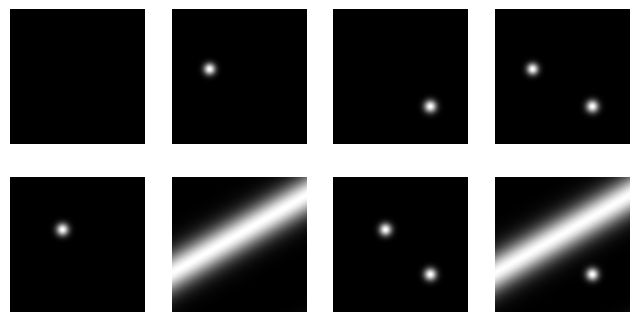

In [666]:
arbitrary_phosphene = create_grating((256/.5), np.pi/3, -np.pi/4, 256).to(device)
arbitrary_phosphene = torch.abs(arbitrary_phosphene) + .01
simulator.phosphene_maps[3] = arbitrary_phosphene 


#
stim = binary(torch.arange(8, device=device),3).float() * SCALE
phs = simulator(interaction_model(stim))

fig, axs = plt.subplots(2,4, figsize=(8,4))
for i in range(2):
    for j in range(4):
        plot(phs[4*i+j], ax=axs[i][j])

### Phosphenes with non-fixed locations

Note that this requires slight adaptation of the simulator code:
- Phosphene maps are stored as meshgrid containing the x and y coordinates of the phosphenes
- Offsets (initialized as dynaphos.State) are used to displace the phosphenes
- Radial distance from the phosphene centers is calculated for each pixel in the gaussian_activation step.

In [949]:
from dynaphos.simulator import State
from typing import Optional, Tuple, Union
from types import MethodType

# read parameters from yaml file
params = utils.load_params(os.path.join(BASE_PATH, 'config','params.yaml'))
params['run']['gpu'] = 0
params['thresholding']['use_threshold'] = False
params['run']['batch_size'] = 8
params['sampling']['sampling_method'] = "center"
params['run']['view_angle'] = 9 #in degrees, horizontal view angle
params['run']['origin'] = [15,15]

# Defines whether to store gradients can optimized 
params['adaptive_offsets'] = {'store_gradients': False}

class Offset(State):
    def __init__(self, params: dict, shape: Tuple[int, ...],
                 verbose: Optional[bool] = False, store_gradients=False):
        self.store_gradients = params['adaptive_offsets']['store_gradients']
        super().__init__(params, shape, verbose)
        
    def reset(self):
        self.state = torch.nn.Parameter(torch.zeros(self.shape, **self.data_kwargs))
        self.state.requires_grad = self.store_gradients
        
    def set_update_rule(self, new_func):
        """Use this method to set a custom update function for the offset values"""
        self.update = MethodType(new_func, self)
        
    def update(self, *args, **kwargs):
        pass


class AdaptiveLocationsSimulator(PhospheneSimulator):
    def __init__(self,*args,**kwargs):
        super().__init__(*args, **kwargs) 
        self.x_offset = Offset(params, self.shape,)
        self.y_offset = Offset(params, self.shape,)
    
    def gaussian_activation(self) -> torch.Tensor:
        """Generate gaussian activation maps, based on sigmas and phosphene
        mapping.

        :return: Stack of Gaussian-shaped phosphene images
        (n_phosphenes, resolution_y, resolution_x)
        """
        x = self.x - self.x_offset.state
        y = self.y - self.y_offset.state
        self.phosphene_maps = torch.sqrt(x ** 2 + y ** 2) # radial distance from phosphene center

        # Calculate normalized Gaussian (peak has value 1).
        sigma = self.sigma.get().clamp(1e-22, None)  # TODO: clamping redundant? Default division by zero gives inf.
        exp = torch.exp(-0.5 * (self.phosphene_maps / sigma) ** 2)
        return exp

    def generate_phosphene_maps(self, coordinates: Map,
                            remove_invalid: Optional[bool] = True,
                            theta: Optional[np.ndarray] = None,
                            ) -> torch.Tensor:
        """Generate phosphene maps (for each phosphene distance to each pixel).

        :param coordinates: Coordinates of phosphenes.
        :param remove_invalid: Whether to remove phosphenes out of view.
        :param theta: Orientations for gabor filtering (if 'gabor_filtering' set to True)
        :return: an (n_phosphenes x resolution[0] x resolution[1]) array
        describing distances from phosphene locations
        """

        # Phosphene coordinates
        x_coords, y_coords = coordinates.cartesian
        x_coords = torch.reshape(self.to_tensor(x_coords), (-1, 1, 1))
        y_coords = torch.reshape(self.to_tensor(y_coords), (-1, 1, 1))

        # x,y limits of the simulation
        res_x, res_y = self.params['run']['resolution']
        x_org, y_org = self.params['run']['origin']
        hemi_fov = self.params['run']['view_angle'] / 2
        x_min, x_max = x_org - hemi_fov, x_org + hemi_fov
        y_min, y_max = y_org - hemi_fov, y_org + hemi_fov

        if remove_invalid:
            # Check if phosphene locations are inside of view angle.
            valid = (
                torch.ge(x_coords, x_min) & torch.less(x_coords, x_max) &
                torch.ge(y_coords, y_min) & torch.less(y_coords, y_max)).ravel()
            num_total = len(x_coords)
            num_valid = torch.sum(valid)
            logging.debug(f"{num_total - num_valid} of {num_total} phosphenes "
                          f"are outside of view and will be removed.")
            x_coords = x_coords[valid]
            y_coords = y_coords[valid]
            coordinates.use_subset(to_numpy(valid))

        # Get distance maps to phosphene centres (in degrees of visual angle).
        device = self.data_kwargs['device']
        num_phosphenes = len(x_coords)

        x_range = torch.linspace(x_min, x_max, res_x, device=device)
        y_range = torch.linspace(y_min, y_max, res_y, device=device)

        grid = torch.meshgrid(x_range, y_range, indexing='xy')
        grid_x = torch.tile(grid[0], (num_phosphenes, 1, 1))
        grid_y = torch.tile(grid[1], (num_phosphenes, 1, 1))

        self.x = grid_x - x_coords
        self.y = grid_y - y_coords
    

        # Phosphene maps are stored (for compatability with the parent class)
        self.phosphene_maps = torch.sqrt(self.x ** 2 + self.y ** 2)
        
        return self.phosphene_maps
    
    
    def update(self, amplitude: torch.Tensor,
               pulse_width: Optional[torch.Tensor] = None,
               frequency: Optional[torch.Tensor] = None):
       
        if pulse_width is None:
            pulse_width = self._pulse_width
        if frequency is None:
            frequency = self._frequency

        charge_per_s = self.get_current(amplitude.view(self.shape),
                                        frequency.view(self.shape),
                                        pulse_width.view(self.shape))

        self.x_offset.update(self.x, charge_per_s) # update as funciton of default position and the stimulation strength
        self.y_offset.update(self.y, charge_per_s)
        
        super().update(amplitude,pulse_width,frequency)

#### Neutral positions 

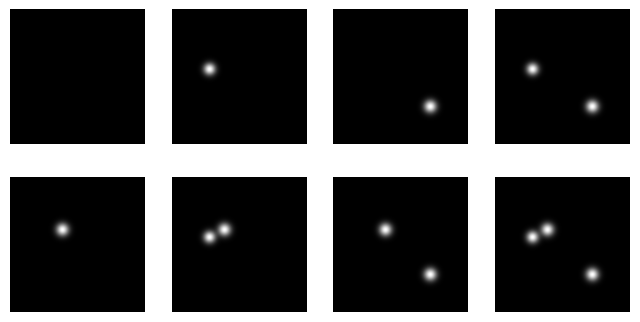

In [950]:
# Phosphene coordinates
x, y= ([13,17, 14], [15.5, 13, 16])
phosphene_coordinates = Map(np.array(x), np.array(y))
simulator = AdaptiveLocationsSimulator(params, phosphene_coordinates)

# Useful variables 
device = simulator.data_kwargs['device']
batch_size, n_phosphenes =  simulator.shape[:2]
n_electrodes = len(x)


# Stimulation
stim = binary(torch.arange(8, device=device),3) * 100e-6
phs = simulator(stim)

fig, axs = plt.subplots(2,4, figsize=(8,4))
for i in range(2):
    for j in range(4):
        plot(phs[4*i+j], ax=axs[i][j])

#### Merging phosphenes

In [951]:
def move_towards_another(self, position, charge_per_sec, phosphene_idx = [0,2], cps_max=3e-6):
    """Offset method for moving the phosphenes towards another as function of the charge per second"""
    p0, p1 = phosphene_idx
    diff = (position[p0,0,0]-self.state[:,p0]) - (position[p1,0,0] - self.state[:,p1])
    
    
    charge_per_sec[p0] / cps_max

    self.state[:,p0] += .5 * diff * (charge_per_sec[:,p1] / cps_max).clip(0,1)
    self.state[:,p1] -= .5 * diff *(charge_per_sec[:,p0] / cps_max).clip(0,1)
    
    # TODO improve this rule (preferably not dependent on cps_max)
    



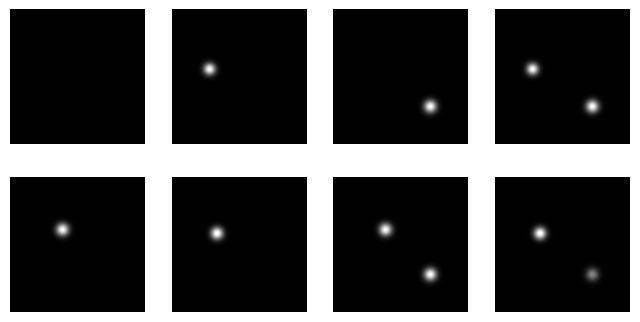

In [952]:
# Phosphene coordinates
x, y= (np.array([13,17, 14]), np.array([15.5, 13, 16]))
phosphene_coordinates = Map(x,y)
simulator = AdaptiveLocationsSimulator(params, phosphene_coordinates)
simulator.x_offset.set_update_rule(new_func= move_towards_another)
simulator.y_offset.set_update_rule(new_func= move_towards_another)

# Useful variables 
device = simulator.data_kwargs['device']
batch_size, n_phosphenes =  simulator.shape[:2]
n_electrodes = len(x)


# Stimulation
stim = binary(torch.arange(8, device=device),3) * 100e-6
phs = simulator(stim)

fig, axs = plt.subplots(2,4, figsize=(8,4))
for i in range(2):
    for j in range(4):
        plot(phs[4*i+j], ax=axs[i][j])

#### Offsets learned end-to-end 

In [954]:

# read parameters from yaml file
params = utils.load_params(os.path.join(BASE_PATH, 'config','params.yaml'))
params['run']['gpu'] = 0
params['thresholding']['use_threshold'] = False
params['run']['batch_size'] = 8
params['sampling']['sampling_method'] = "center"
params['run']['view_angle'] = 9 #in degrees, horizontal view angle
params['run']['origin'] = [15,15]

# Defines whether to store gradients can optimized 
params['adaptive_offsets'] = {'store_gradients': True}

In [955]:
# TODO